## Demo notebook for accessing MODIS data on Azure

This notebook provides an example of accessing MODIS data from blob storage on Azure, including (1) finding the MODIS tile corresponding to a lat/lon coordinate, (2) retrieving that tile from blob storage, and (3) displaying that tile using the [rasterio](https://github.com/mapbox/rasterio) library.  

This notebook uses the MODIS surface reflectance product as an example, but data structure and access will be the same for other MODIS products.

MODIS data are stored in the East US data center, so this notebook will run most efficiently on Azure compute located in East US.  We recommend that substantial computation depending on MODIS data also be situated in East US.  You don't want to download hundreds of terabytes to your laptop!  If you are using MODIS data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports and environment

In [1]:
# Standard or standard-ish imports
import os
import tempfile
import numpy as np
import shutil
import urllib
import matplotlib.pyplot as plt

# Less standard, but still pip- or conda-installable
import rasterio

# pip install azure-storage-blob
from azure.storage.blob import ContainerClient

# Storage locations are documented at http://aka.ms/ai4edata-modis
modis_account_name = 'modissa'
modis_container_name = 'modis'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(),'modis')
os.makedirs(temp_dir,exist_ok=True)

# This file is provided by NASA; it indicates the lat/lon extents of each
# MODIS tile.
#
# The file originally comes from:
#
# https://modis-land.gsfc.nasa.gov/pdf/sn_bound_10deg.txt
modis_tile_extents_url = modis_blob_root + '/sn_bound_10deg.txt'

# Load this file into a table, where each row is (v,h,lonmin,lonmax,latmin,latmax)
modis_tile_extents = np.genfromtxt(modis_tile_extents_url,
                     skip_header = 7, 
                     skip_footer = 3)

# Read-only shared access signature (SAS) URL for the MODIS container
modis_sas_token = 'st=2019-07-26T17%3A21%3A46Z&se=2029-07-27T17%3A21%3A00Z&sp=rl&sv=2018-03-28&sr=c&sig=1NpBV6P8SIibRcelWZyLCpIh4KFiqEzOipjKU5ZIRrQ%3D'

modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                         credential=None)

### Functions

In [2]:
def lat_lon_to_modis_tile(lat,lon):
    """
    Get the modis tile indices (h,v) for a given lat/lon
    
    https://www.earthdatascience.org/tutorials/convert-modis-tile-to-lat-lon/
    """
    
    found_matching_tile = False
    i = 0
    while(not found_matching_tile):
        found_matching_tile = lat >= modis_tile_extents[i, 4] \
        and lat <= modis_tile_extents[i, 5] \
        and lon >= modis_tile_extents[i, 2] and lon <= modis_tile_extents[i, 3]
        i += 1
        
    v = int(modis_tile_extents[i-1, 0])
    h = int(modis_tile_extents[i-1, 1])
    
    return h,v


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_tiff_blobs_in_folder(container_name,folder_name):
    """"
    List .tiff files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.tiff')]
    return files
             

def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('.', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url)))
        return destination_filename
    print('Downloading file {}'.format(os.path.basename(url)),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename

### Access and plot a MODIS tile


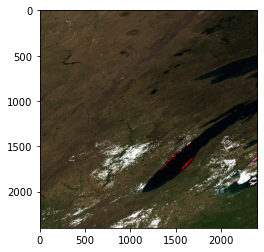

In [3]:
# Files are stored according to:
#
# http://modissa.blob.core.windows.net/[product]/[htile]/[vtile]/[year][day]/filename

# Surface reflectance
product = 'MCD43A4'

# Let's look at the tile containing Chicago, IL, on May 15, 2019 (day of year 135)
h,v = lat_lon_to_modis_tile(41.881832,-87.623177)
daynum = '2019135'
folder = product + '/' + '{:0>2d}/{:0>2d}'.format(h,v) + '/' + daynum

# Find all .tiff files from this tile on this day, one file per channel
files = list_tiff_blobs_in_folder(modis_container_name,folder)

norm_value = 4000

# Channel 7 in a MCD43A4 file corresponds to MODIS band 1.  
#
# Let's map bands 1, 4, and 3 (channels 7,10,9) to RGB.
channels = [7,10,9]
image_data = []
for ifn in channels:
    remote_fn = files[ifn]
    url = modis_blob_root + '/' + remote_fn
    fn = download_url(url)
    raster = rasterio.open(fn,'r')
    band_array = raster.read(1)
    raster.close()
    band_array = band_array / norm_value
    image_data.append(band_array)
rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)

### Clean up temporary files

In [4]:
shutil.rmtree(temp_dir)